In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
)
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import random
import platform

In [2]:
# Фиксация всех случайных seed для воспроизводимости
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # если используются многопоточные GPU
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(SEED)  # если используется стандартный модуль random


# Для воспроизводимости DataLoader при использовании многопоточности
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


g = torch.Generator()
g.manual_seed(SEED)

In [3]:
# Определяем параметры в зависимости от ОС
if platform.system() == "Windows":
    num_workers = 0  # На Windows рекомендуется использовать 0, чтобы избежать проблем с производительностью и совместимостью. :contentReference[oaicite:2]{index=2}
    torch.multiprocessing.set_start_method(
        "spawn", force=True
    )  # Windows использует метод 'spawn' для запуска процессов.
else:
    num_workers = (
        os.cpu_count()
    )  # На Linux можно использовать количество ядер процессора для num_workers.
    # Linux по умолчанию использует метод 'fork', который обычно работает быстрее.

1. Загрузка библиотек и настройка параметров

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

2. Подготовка и предобработка данных

2.1. Датасеты

В статье используются публичные датасеты, содержащие как нормальный сетевой трафик, так и аномальные/злоумышленные потоки. Например, можно попробовать использовать:

- USTC-TFC (University of Science and Technology of China – Traffic Flow Collection)

- Другие датасеты для сетевого обнаружения аномалий

2.2. Предобработка

Согласно статье, на вход модели подаются первые n пакетов каждого сетевого потока, причем:

- Фильтрация: Выбираются пакеты, принадлежащие одному 5-тuple (IP-адреса, порты, протокол).

- Анонимизация: MAC- и IP-адреса маскируются.

- Трансформация: Каждый пакет приводится к фиксированной длине l (если пакет длиннее – усечение, если короче – дополнение нулями).

- Нормализация: Значения байтов нормализуются (например, делением на 255).

- Конкатенация: n пакетов объединяются в единый входной вектор.

Пример кода для обработки может выглядеть следующим образом (упрощённо):

In [5]:
# Класс Dataset для загрузки данных из CSV
class CSVAttackDataset(Dataset):
    def __init__(self, attack_dir, data_type='normal', transform=None):
        """
        attack_dir: путь к папке с CSV-файлами атаки (например, 'sql-inj')
        data_type: 'attack' или 'normal'
        """
        self.file_path = os.path.join(attack_dir, f"{os.path.basename(attack_dir)}_{data_type}.csv")
        self.data = self._load_and_filter_data()
        self.transform = transform

    def _load_and_filter_data(self):
        if not os.path.exists(self.file_path):
            return pd.DataFrame()

        df = pd.read_csv(self.file_path)
        # Фильтрация данных (для обучения используем только нормальный трафик)
        df = df[df['label'] == 0] if 'normal' in self.file_path else df
        return df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        # Извлекаем байты и нормализуем в [0, 1]
        features = sample.filter(like='byte_').values.astype(np.float32) / 255.0
        tensor = torch.tensor(features, dtype=torch.float32)
        # Добавляем размерность канала: [1, input_length]
        return tensor.unsqueeze(0)

In [6]:
# Класс для комбинированного тестового набора
class CombinedTestDataset(Dataset):
    def __init__(self, attack_dir):
        attack_df = pd.read_csv(os.path.join(attack_dir, f"{os.path.basename(attack_dir)}_attack.csv"))
        normal_df = pd.read_csv(os.path.join(attack_dir, f"{os.path.basename(attack_dir)}_normal.csv"))
        self.data = pd.concat([attack_df, normal_df], ignore_index=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        features = sample.filter(like='byte_').values.astype(np.float32) / 255.0
        label = sample['label']
        return torch.tensor(features).unsqueeze(0), torch.tensor(label, dtype=torch.float32)

In [7]:
# # Определяем кастомный Dataset для pcap-файлов
# class PCAPDataset(Dataset):
#     def __init__(self, dataset_file):
#         # Загружаем и обрабатываем данные из pcap-файла
#         # self.data = group_packets_by_flow(pcap_file, n_packets, l)
#         self.dataset = np.load(dataset_file)  # Загрузка одной строкой
#
#     def __len__(self):
#         return len(self.dataset)
#
#     def __getitem__(self, idx):
#         # Преобразуем выбранный элемент в тензор и добавляем размер канала (если требуется)
#         sample = self.dataset[idx]
#         sample = torch.tensor(sample, dtype=torch.float32)
#         # Добавляем размер канала, т.е. форма [1, input_length]
#         return sample.unsqueeze(0)

In [8]:
# # Создаём Dataset. При необходимости задайте число пакетов (n_packets) и фиксированную длину (l)
# dataset_file = 'dataset.npy'
# dataset = PCAPDataset(dataset_file)
#
# # Разбиение данных на обучающую, валидационную и тестовую выборки (например, 70%-15%-15%)
# train_size = int(0.7 * len(dataset))
# test_size = len(dataset) - train_size
#
# train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, test_size])
#
# # Создаём DataLoader-ы
# batch_size = 32
#
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
#
# # Пример: проход по одному батчу обучающего DataLoader-а
# for batch in train_loader:
#     print("Размер батча:", batch.shape)  # Ожидается [batch_size, 1, n_packets * l]
#     break

3. Модель и архитектура

ARCADE состоит из двух компонентов:

3.1. Автоэнкодер (AE)

Используется компактная свёрточная архитектура (inspired by DCGAN) для кодирования и декодирования входных сетевых потоков.

Основная идея:

- Encoder: Преобразует входной сигнал в компактное латентное представление.

- Decoder: Восстанавливает исходный сигнал из латентного представления.

3.2. Критик (Critic)

Отдельная нейросеть, выполняющая роль дискриминатора (как в WGAN-GP), оценивающая, насколько реконструкция (выход AE) соответствует нормальному распределению трафика. При обучении используется штраф за градиент (gradient penalty) для соблюдения условий липшицевости.

In [9]:
# Параметры (пример)
# l = 100  # длина каждого пакета
# n_packets = 2  # число пакетов, объединяемых в поток
# input_length = l * n_packets
# latent_dim = 64


# Автоэнкодер (свёрточный)
# class Encoder(nn.Module):
#     def __init__(self):
#         super(Encoder, self).__init__()
#         self.encoder = nn.Sequential(
#                 nn.Conv1d(1, 16, kernel_size=3, stride=2, padding=1),
#                 nn.ReLU(),
#                 nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),
#                 nn.ReLU(),
#                 nn.Flatten(),
#                 nn.Linear(32 * (input_length // 4), latent_dim)
#                 )
#
#     def forward(self, x):
#         return self.encoder(x)


# class Decoder(nn.Module):
#     def __init__(self):
#         super(Decoder, self).__init__()
#         self.decoder = nn.Sequential(
#                 nn.Linear(latent_dim, 32 * (input_length // 4)),
#                 nn.ReLU(),
#                 nn.Unflatten(1, (32, input_length // 4)),
#                 nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
#                 nn.ReLU(),
#                 nn.ConvTranspose1d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
#                 nn.Sigmoid()  # Если нормализованные данные в [0,1]
#                 )
#
#     def forward(self, x):
#         return self.decoder(x)

In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
                # Input: (batch, 1, 200)
                nn.Conv1d(1, 16, kernel_size=4, stride=2, padding=1),  # Output: (16, 100)
                nn.BatchNorm1d(16),
                nn.LeakyReLU(),

                nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 50)
                nn.BatchNorm1d(32),
                nn.LeakyReLU(),

                nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 25)
                nn.BatchNorm1d(64),
                nn.LeakyReLU(),

                nn.Flatten(),
                nn.Linear(64 * 25, 50, bias=False)  # Parameters: 64*25*50 = 80,000
                )

    def forward(self, x):
        return self.model(x)

In [11]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
                # Input: (batch, 50)
                nn.Linear(50, 64 * 25, bias=False),  # Parameters: 50*64*25 = 80,000
                nn.Unflatten(1, (64, 25)),  # Reshape to (64, 25)

                nn.BatchNorm1d(64),
                nn.ReLU(),

                nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 50)
                nn.BatchNorm1d(32),
                nn.ReLU(),

                nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),  # Output: (16, 100)
                nn.BatchNorm1d(16),
                nn.ReLU(),

                nn.ConvTranspose1d(16, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 200)
                nn.Sigmoid()
                )

    def forward(self, x):
        return self.model(x)

In [12]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction

In [13]:
# Критик (аналог дискриминатора из WGAN-GP)
# class Critic(nn.Module):
#     def __init__(self):
#         super(Critic, self).__init__()
#         self.critic = nn.Sequential(
#                 nn.Conv1d(1, 16, kernel_size=3, stride=2, padding=1),
#                 nn.LeakyReLU(0.2),
#                 nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),
#                 nn.LeakyReLU(0.2),
#                 nn.Flatten(),
#                 nn.Linear(32 * (input_length // 4), 1)
#                 )
#
#     def forward(self, x):
#         return self.critic(x)

In [14]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()

        self.model = nn.Sequential(
                # Input: (batch, 1, 200)
                nn.Conv1d(1, 16, kernel_size=4, stride=2, padding=1),  # Output: (16, 100)
                nn.LayerNorm([16, 100]),
                nn.LeakyReLU(),

                nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 50)
                nn.LayerNorm([32, 50]),
                nn.LeakyReLU(),

                nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 25)
                nn.LayerNorm([64, 25]),
                nn.LeakyReLU(),

                nn.Flatten(),
                nn.Linear(64 * 25, 50, bias=False),  # Parameters: 64*25*50 = 80,000
                nn.LayerNorm(50),
                nn.LeakyReLU(),

                nn.Linear(50, 1, bias=False)  # Parameters: 50*1 = 50
                )

    def forward(self, x):
        return self.model(x)

4. Функции потерь и штраф за градиент

4.1. Функция реконструкции

Чаще всего используется MSE (Mean Squared Error) или L1 loss:

4.2. Adversarial loss (WGAN-GP)

Критик обучается по следующему принципу:

- Максимизировать оценку для реальных нормальных потоков.

- Минимизировать оценку для реконструкций, полученных автоэнкодером.

При этом применяется штраф за градиент, как описано в статье (см. уравнение (4)).

Пример функции для расчёта gradient penalty:

In [15]:
def compute_gradient_penalty(critic, real_data, fake_data, device, lambda_gp=10):
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1, 1, device=device)
    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates.requires_grad_(True)
    critic_interpolates = critic(interpolates)
    gradients = grad(
            outputs=critic_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones_like(critic_interpolates, device=device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
            )[0]
    gradients = gradients.view(batch_size, -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_gp
    return gradient_penalty

5. Процедура обучения

5.1. Стратегия обучения

Архитектура обучается по схеме adversarial training:

- Шаг 1. Обучение критика:
    - Используйте реальные нормальные данные и реконструкции автоэнкодера.

    - Обновляйте веса критика, максимизируя разницу между оценками (реальные – реконструированные), добавляя штраф за градиент.

- Шаг 2. Обучение автоэнкодера:

    - Минимизируйте комбинированную функцию потерь, состоящую из ошибки реконструкции и adversarial loss (то есть, ошибка между оценкой критика для реконструкций и целевым значением).

5.2. Пример цикла обучения

Ниже приведён псевдокод, демонстрирующий общий цикл обучения:

In [16]:
# # Инициализация
# autoencoder = Autoencoder().to(device)
# critic = Critic().to(device)
#
# optimizer_AE = optim.Adam(autoencoder.parameters(), lr=1e-4)
# optimizer_Critic = optim.Adam(critic.parameters(), lr=1e-4)
#
# num_epochs = 50
# critic_iters = 5  # число обновлений критика на один шаг автоэнкодера
# lambda_gp = 10
#
# for epoch in range(num_epochs):
#     for batch in dataloader:  # dataloader должен возвращать батчи нормальных сетевых потоков
#         real_data = batch.to(device)  # форма: [batch_size, 1, input_length]
#
#         # Обновление критика
#         for _ in range(critic_iters):
#             optimizer_Critic.zero_grad()
#
#             # Получаем реконструкцию от автоэнкодера (без обновления его параметров)
#             with torch.no_grad():
#                 fake_data = autoencoder(real_data)
#
#             critic_real = critic(real_data)
#             critic_fake = critic(fake_data)
#
#             # Потеря критика (максимизировать разницу)
#             loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
#             gp = compute_gradient_penalty(critic, real_data, fake_data, device, lambda_gp)
#             loss_critic += gp
#
#             loss_critic.backward()
#             optimizer_Critic.step()
#
#         # Обновление автоэнкодера
#         optimizer_AE.zero_grad()
#
#         reconstructed = autoencoder(real_data)
#         critic_reconstructed = critic(reconstructed)
#
#         # Потеря автоэнкодера: ошибка реконструкции + adversarial loss
#         loss_reconstruction = reconstruction_loss(reconstructed, real_data)
#         # Цель – сделать оценку критика для реконструкций близкой к оценке для реальных данных
#         loss_adv = - torch.mean(critic_reconstructed)
#
#         loss_AE = loss_reconstruction + loss_adv
#         loss_AE.backward()
#         optimizer_AE.step()
#
#     print(f"Epoch {epoch + 1}/{num_epochs}: Loss_AE={loss_AE.item()}, Loss_Critic={loss_critic.item()}")


In [17]:
def evaluate_validation(autoencoder, val_loader, device, reconstruction_criterion):
    autoencoder.eval()
    val_loss = 0.0
    count = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            reconstruction = autoencoder(data)
            loss = reconstruction_criterion(reconstruction, data)
            val_loss += loss.item() * data.size(0)
            count += data.size(0)
    autoencoder.train()
    return val_loss / count

In [18]:
def train_arcade(
    autoencoder,
    critic,
    train_loader,
    val_loader,
    device,
    searching_epochs=100,
    fine_tuning_epochs=50,
    lr_searching=1e-4,
    lr_finetuning=1e-5,
    lambda_gp=10,
    lambda_adv=0.01,
    critic_iters=5,
    balance_threshold=0.001,
    balance_patience=5,
    early_stopping_patience=10,
):
    total_epochs = searching_epochs + fine_tuning_epochs

    # Инициализация оптимизаторов с β1=0, β2=0.9
    optimizer_AE = optim.Adam(autoencoder.parameters(), lr=lr_searching, betas=(0, 0.9))
    optimizer_Critic = optim.Adam(critic.parameters(), lr=lr_searching, betas=(0, 0.9))

    reconstruction_criterion = nn.MSELoss()

    best_val_loss = float("inf")
    epochs_without_improvement = 0
    balance_counter = (
        0  # Количество последовательных эпох, когда разница лоссов меньше порога
    )

    epoch = 0
    while epoch < total_epochs:
        total_loss_ae = 0.0
        total_loss_critic = 0.0
        num_batches = 0

        # Если перешли в фазу fine-tuning, обновляем lr оптимизаторов
        if epoch == searching_epochs:
            for param_group in optimizer_AE.param_groups:
                param_group["lr"] = lr_finetuning
            for param_group in optimizer_Critic.param_groups:
                param_group["lr"] = lr_finetuning

        batch_pbar = tqdm(
            enumerate(train_loader),
            total=len(train_loader),
            desc=f"Epoch {epoch + 1}/{total_epochs}",
            unit="batch",
            leave=False,
        )

        for _, real_data in batch_pbar:
            real_data = real_data.to(device)

            # Обновление критика (несколько итераций)
            critic_loss_epoch = 0.0
            for _ in range(critic_iters):
                optimizer_Critic.zero_grad()
                reconstruction = autoencoder(real_data)
                critic_real = critic(real_data)
                critic_fake = critic(reconstruction.detach())
                gp = compute_gradient_penalty(
                    critic, real_data, reconstruction.detach(), device, lambda_gp
                )
                loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake)) + gp
                loss_critic.backward()
                optimizer_Critic.step()
                critic_loss_epoch += loss_critic.item()
            avg_critic_loss = critic_loss_epoch / critic_iters

            # Обновление автоэнкодера
            optimizer_AE.zero_grad()
            reconstruction = autoencoder(real_data)
            loss_reconstruction = reconstruction_criterion(reconstruction, real_data)
            loss_adv = -torch.mean(critic(reconstruction))
            loss_AE = loss_reconstruction + lambda_adv * loss_adv
            loss_AE.backward()
            optimizer_AE.step()

            total_loss_ae += loss_AE.item()
            total_loss_critic += avg_critic_loss
            num_batches += 1

            batch_pbar.set_postfix(
                {
                    "MSE Loss": f"{loss_reconstruction:.4f}",
                    "AE Loss": f"{loss_AE.item():.4f}",
                    "Critic Loss": f"{avg_critic_loss:.4f}",
                }
            )
            # tqdm.write(
            #     f"MSE Loss: {loss_reconstruction:.4f}, AE Loss: {loss_AE.item():.4f}, Critic Loss: {avg_critic_loss:.4f}"
            # )

        batch_pbar.close()

        avg_ae_loss = total_loss_ae / num_batches
        avg_critic_loss = total_loss_critic / num_batches

        # Проверка условия балансировки лоссов
        if abs(avg_ae_loss - avg_critic_loss) < balance_threshold:
            balance_counter += 1
        else:
            balance_counter = 0

        # Вычисляем ошибку на валидационном наборе
        val_loss = evaluate_validation(
            autoencoder, val_loader, device, reconstruction_criterion
        )
        # print(
        #     f"- Epoch {epoch + 1}: Avg AE Loss = {avg_ae_loss:.4f}, Avg Critic Loss = {avg_critic_loss:.4f}, Val Loss = {val_loss:.4f}"
        # )

        # Раннее прекращение по валидации
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Если баланс достигнут в течение balance_patience эпох или нет улучшения валидации
        if balance_counter >= balance_patience:
            print("Баланс между лоссами достигнут, остановка обучения.")
            break
        if epochs_without_improvement >= early_stopping_patience:
            print("Нет улучшения на валидации, early stopping.")
            break

        epoch += 1
    print("Обучение завершено.")

In [19]:
# def train_arcade(autoencoder, critic, train_loader, num_epochs, device):
#     optimizer_AE = optim.Adam(autoencoder.parameters(), lr=1e-4, betas=(0.0, 0.9))
#     optimizer_Critic = optim.Adam(critic.parameters(), lr=1e-4, betas=(0.0, 0.9))
#
#     reconstruction_criterion = nn.MSELoss()  # можно заменить на другую функцию потерь, например, L1
#
#     lambda_gp = 10  # коэффициент для штрафа градиента (см. формулу (4))
#     lambda_adv = 1  # вес для адвесариальной потери
#
#     critic_iters = 5  # число обновлений критика на один шаг автоэнкодера
#
#     # Инициализация прогресс-бара для эпох
#     # epoch_pbar = tqdm(range(num_epochs), desc="Training", unit="epoch")
#
#     for epoch in range(num_epochs):  #epoch_pbar:
#         # Прогресс-бар для батчей внутри эпохи
#         batch_pbar = tqdm(enumerate(train_loader), total=len(train_loader),
#                           desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch"
#                           )
#
#         total_loss_ae = 0.0
#         total_loss_critic = 0.0
#
#         for i, real_data in batch_pbar:
#             real_data = real_data.to(device)
#
#             # Обновление критика
#             critic_loss = 0.0
#             for _ in range(critic_iters):
#                 # Обновление критика
#                 optimizer_Critic.zero_grad()
#                 # Реконструкция через автоэнкодер
#                 reconstruction = autoencoder(real_data)
#                 # Получение оценок критика для реальных и реконструированных данных
#                 critic_real = critic(real_data)
#                 critic_fake = critic(reconstruction.detach())
#                 # Вычисление штрафа градиента согласно формуле (4)
#                 gp = compute_gradient_penalty(critic, real_data, reconstruction.detach(), device, lambda_gp)
#                 # Потеря критика (см. формулу (3)): L_C = E[C(x)] - E[C(G(x))] + λ * L_GP
#                 loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake)) + gp
#                 loss_critic.backward()
#                 optimizer_Critic.step()
#                 # Обновление статистики
#                 critic_loss += loss_critic.item()
#
#             # Обновление автоэнкодера
#             optimizer_AE.zero_grad()
#             reconstruction = autoencoder(real_data)
#             # Реконструктивная ошибка
#             loss_reconstruction = reconstruction_criterion(reconstruction, real_data)
#             # Адвесариальная потеря: пытаемся обмануть критика (см. формулу (2))
#             critic_fake_for_gen = critic(reconstruction)
#             loss_adv = -torch.mean(critic_fake_for_gen)
#             # Итоговая потеря автоэнкодера – сумма реконструктивной и адвесариальной потерь
#             loss_AE = loss_reconstruction + lambda_adv * loss_adv
#             loss_AE.backward()
#             optimizer_AE.step()
#
#             # Обновление статистики
#             # total_loss_ae += loss_AE.item()
#             # total_loss_critic += critic_loss / critic_iters  # Усредняем loss критика
#
#             # Обновление описания прогресс-бара батчей
#             batch_pbar.set_postfix({
#                     "MSE Loss"   : f"{loss_reconstruction:.4f}",
#                     "AE Loss"    : f"{loss_AE.item():.4f}",
#                     "Critic Loss": f"{(critic_loss / critic_iters):.4f}"
#                     },
#                     # refresh=False
#                     )
#
#         # Закрываем прогресс-бар батчей
#         batch_pbar.close()
#
#         # Рассчитываем средние потери за эпоху
#         # avg_loss_ae = total_loss_ae / len(train_loader)
#         # avg_loss_critic = total_loss_critic / len(train_loader)
#
#         # Обновление описания основного прогресс-бара
#         # epoch_pbar.set_postfix({
#         #         "Avg AE Loss"    : f"{avg_loss_ae:.4f}",
#         #         "Avg Critic Loss": f"{avg_loss_critic:.4f}"
#         #         }
#         #         )
#
#         # Вывод каждые N шагов (если нужно)
#         # if (epoch + 1) % 5 == 0:
#         #     tqdm.write(f"Epoch [{epoch + 1}/{num_epochs}] "
#         #                f"Avg AE Loss: {avg_loss_ae:.4f} "
#         #                f"Avg Critic Loss: {avg_loss_critic:.4f}"
#         #                )
#
#     # Закрываем основной прогресс-бар
#     # epoch_pbar.close()

In [20]:
def evaluate_metrics(autoencoder, dataloader, device):
    all_scores = []
    all_labels = []
    autoencoder.eval()

    # Сбор ошибок реконструкции и меток для всех примеров
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            reconstruction = autoencoder(data)
            # Вычисление ошибки реконструкции (например, среднеквадратичная ошибка по каждому примеру)
            scores = torch.mean((data - reconstruction) ** 2, dim=[1, 2]).cpu().numpy()
            all_scores.extend(scores)
            all_labels.extend(labels.cpu().numpy())

    all_scores = np.array(all_scores)
    all_labels = np.array(all_labels)

    # Вычисление AUROC без пороговой бинаризации
    auroc = roc_auc_score(all_labels, all_scores)

    # Подбор порога на основе максимизации F1-метрики
    thresholds = np.linspace(np.min(all_scores), np.max(all_scores), num=100)
    f1_scores = []
    for thr in thresholds:
        preds = (all_scores > thr).astype(int)
        f1 = f1_score(all_labels, preds)
        f1_scores.append(f1)
    best_threshold = thresholds[np.argmax(f1_scores)]

    # Применение оптимального порога для вычисления остальных метрик
    predictions = (all_scores > best_threshold).astype(int)
    accuracy = accuracy_score(all_labels, predictions)
    precision = precision_score(all_labels, predictions)
    recall = recall_score(all_labels, predictions)
    f1 = f1_score(all_labels, predictions)

    # Вычисление матрицы ошибок
    tn, fp, fn, tp = confusion_matrix(all_labels, predictions).ravel()

    print(f"AUROC: {auroc:.4f}")
    print(f"Лучший threshold: {best_threshold:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"Матрица ошибок:")
    print(f"TN: {tn:.4f}")
    print(f"FP: {fp:.4f}")
    print(f"FN: {fn:.4f}")
    print(f"TP: {tp:.4f}")

    # ------------------ Построение графиков ------------------

    # 1. Гистограмма распределения ошибок реконструкции
    plt.figure(figsize=(12, 5))
    plt.hist(all_scores[all_labels == 0], bins=50, alpha=0.6, label="Нормальные")
    plt.hist(all_scores[all_labels == 1], bins=50, alpha=0.6, label="Аномалии")
    plt.axvline(
        best_threshold,
        color="red",
        linestyle="--",
        label=f"Лучший threshold: {best_threshold:.4f}",
    )
    plt.xlabel("Ошибка реконструкции")
    plt.ylabel("Количество примеров")
    plt.title("Распределение ошибок реконструкции")
    plt.legend()
    plt.show()

    # 2. ROC-кривая
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"ROC кривая (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC кривая")
    plt.legend(loc="lower right")
    plt.show()

    # 3. Зависимость F1-score от порога
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, f1_scores, marker="o")
    plt.xlabel("Threshold")
    plt.ylabel("F1-score")
    plt.title("Зависимость F1-score от порога")
    plt.axvline(
        best_threshold,
        color="red",
        linestyle="--",
        label=f"Лучший threshold: {best_threshold:.4f}",
    )
    plt.legend()
    plt.show()

    return auroc, predictions, accuracy, precision, recall, f1, tn, fp, fn, tp, roc_auc

In [21]:
results = []

In [22]:
def train_attack_category(attack_category, base_dir="n_packets=2_l=100"):
    print(f"\n< ---------- {attack_category} ---------- >")

    # Создаем Dataset только для нормального трафика для обучения
    train_dataset = CSVAttackDataset(
        attack_dir=os.path.join(base_dir, attack_category), data_type="normal"
    )

    # Разбиение на train/validation
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    # Тестовый набор (attack + normal)
    test_dataset = CombinedTestDataset(os.path.join(base_dir, attack_category))

    # Создаем DataLoader-ы
    batch_size = 32

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        worker_init_fn=seed_worker,  # <- для воркеров
        generator=g,  # <- для перемешивания
        num_workers=num_workers,
        pin_memory=(device.type == 'cuda'),  # Рекомендуется при использовании GPU для ускорения передачи данных.
    )

    val_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        worker_init_fn=seed_worker,  # важно, если есть аугментации
        generator=g,  # не влияет при shuffle=False, но для единообразия
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        worker_init_fn=seed_worker,  # если есть преобразования данных
        generator=g,  # можно опустить, но лучше оставить
    )

    # Инициализация моделей
    autoencoder = Autoencoder().to(device)
    critic = Critic().to(device)

    # Обучение ARCADE
    searching_epochs = 10  # Фаза "searching"
    fine_tuning_epochs = 5  # Фаза "fine-tuning"
    train_arcade(autoencoder, critic, train_dataloader, val_dataloader, device)

    # Оценка и сохранение метрик
    auroc, predictions, accuracy, precision, recall, f1, tn, fp, fn, tp, roc_auc = (
        evaluate_metrics(autoencoder, test_dataloader, device)
    )

    # Добавляем результат в список
    results.append(
        {
            "Attack Category": attack_category,
            "AUROC": auroc,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "True Negative": tn,
            "False Positive": fp,
            "False Negative": fn,
            "True Positive": tp,
            "ROC AUC": roc_auc,
        }
    )
    print()


< ---------- botnet-ares ---------- >


Epoch 1/150:   0%|          | 0/206 [00:00<?, ?batch/s]c:\Users\nemo\anaconda3\envs\cuda\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Нет улучшения на валидации, early stopping.
Обучение завершено.
AUROC: 0.4888
Лучший threshold: 0.0000
Accuracy: 0.4871
Precision: 0.4870
Recall: 1.0000
F1: 0.6550
Матрица ошибок:
TN: 1.0000
FP: 7293.0000
FN: 0.0000
TP: 6924.0000


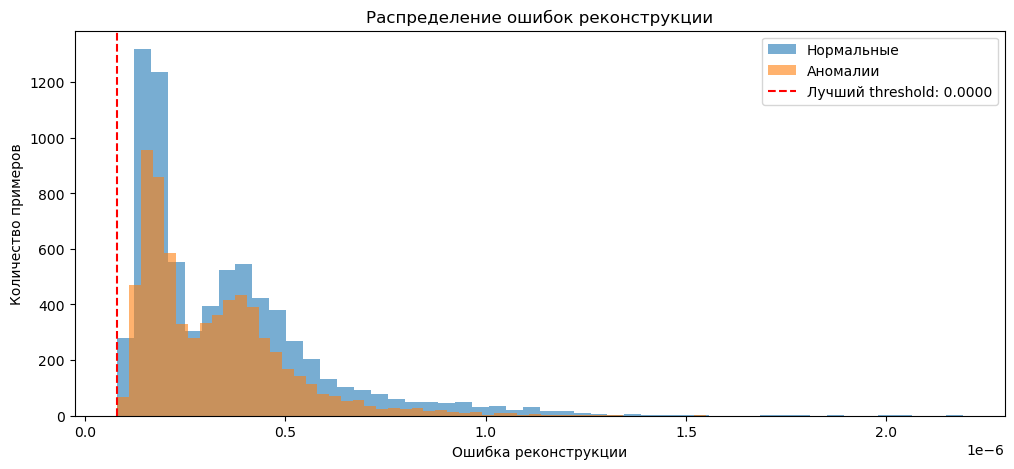

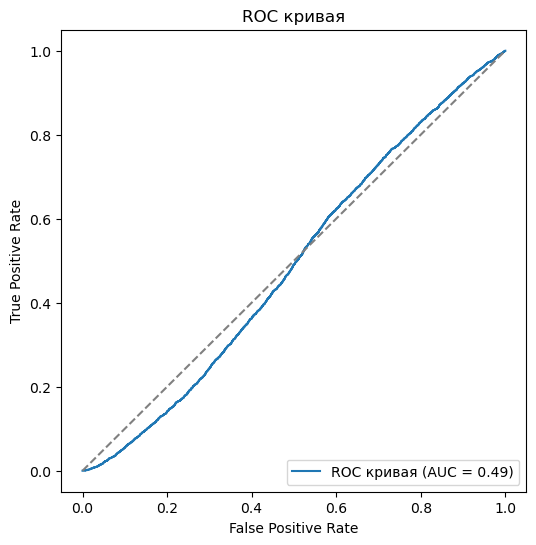

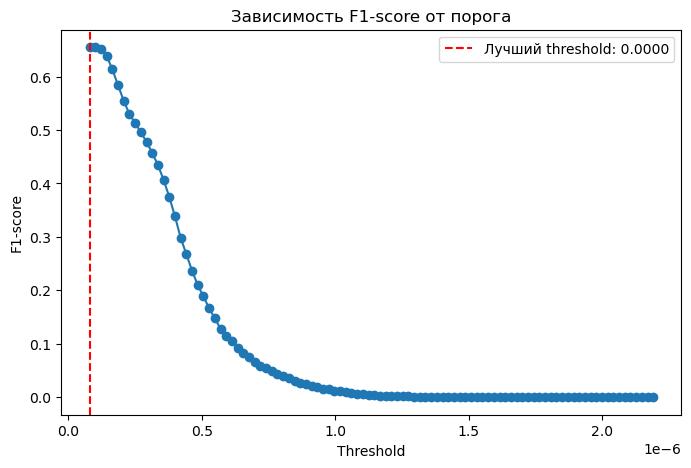

In [23]:
train_attack_category("botnet-ares")


< ---------- brute-ftp ---------- >


Обучение завершено.
AUROC: 0.8967
Лучший threshold: 0.0000
Accuracy: 0.9413
Precision: 0.9413
Recall: 1.0000
F1: 0.9698
Матрица ошибок:
TN: 1.0000
FP: 804.0000
FN: 0.0000
TP: 12896.0000


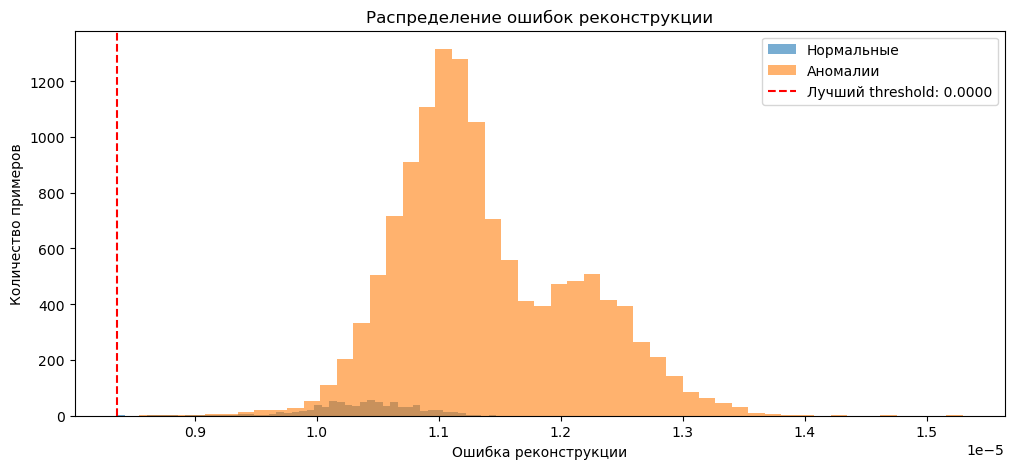

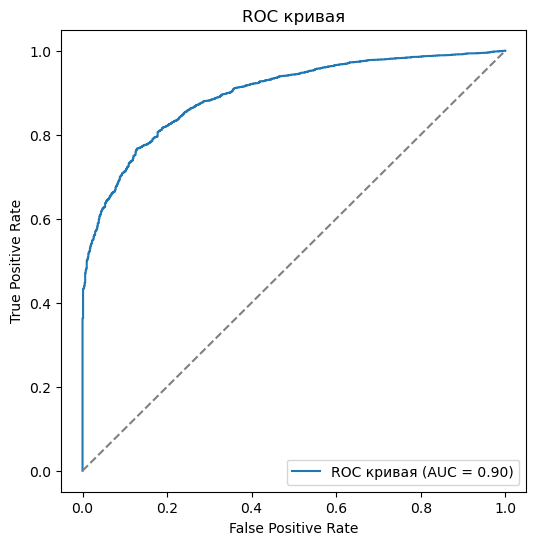

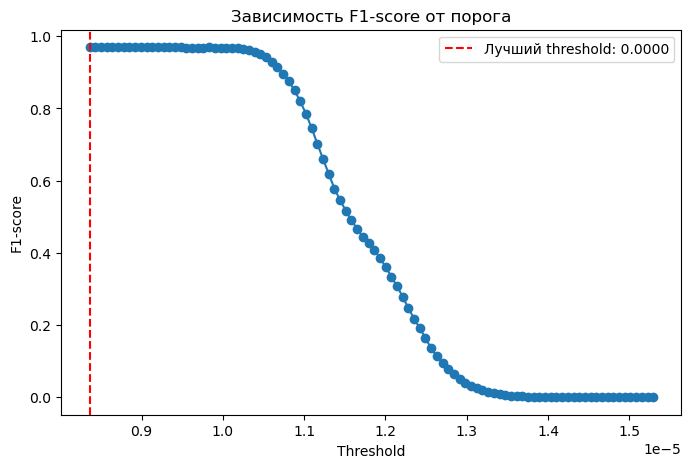

In [24]:
train_attack_category("brute-ftp")


< ---------- brute-http ---------- >


Обучение завершено.
AUROC: 0.2233
Лучший threshold: 0.0170
Accuracy: 0.8453
Precision: 0.8455
Recall: 0.9997
F1: 0.9162
Матрица ошибок:
TN: 0.0000
FP: 565.0000
FN: 1.0000
TP: 3093.0000


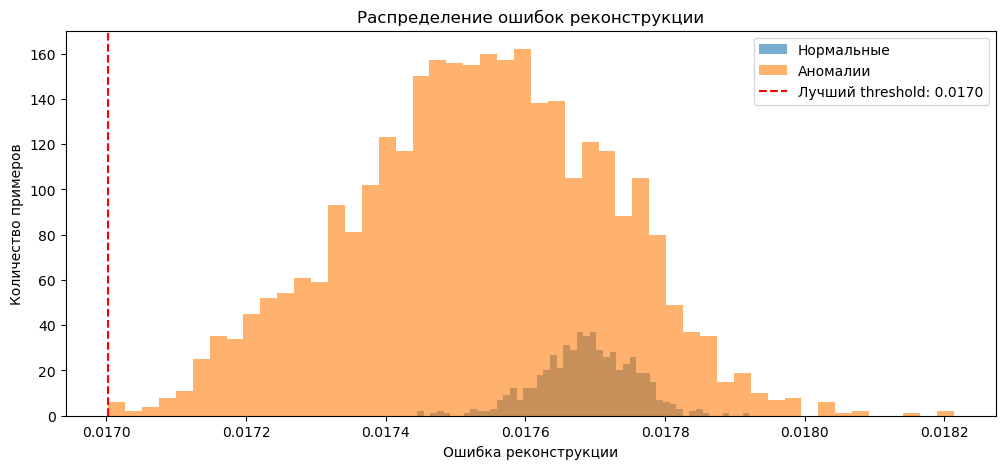

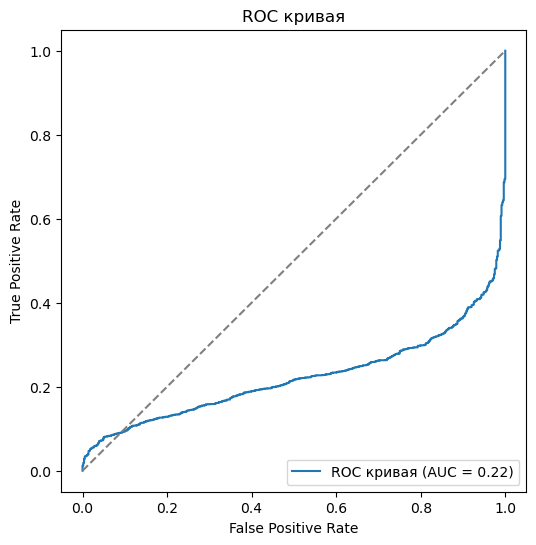

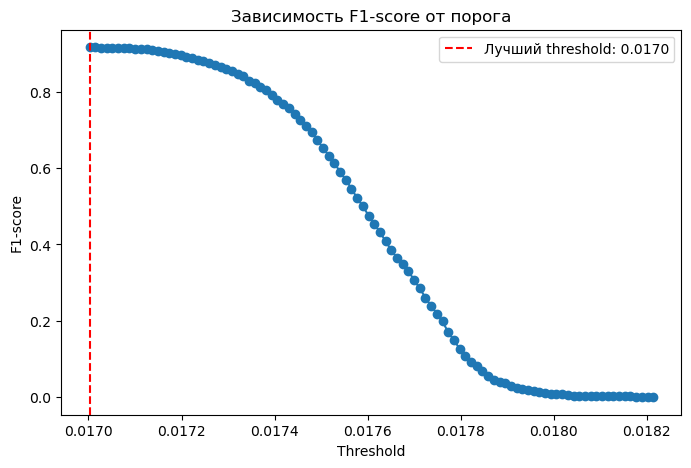

In [25]:
train_attack_category("brute-http")


< ---------- brute-ssh ---------- >


Баланс между лоссами достигнут, остановка обучения.
Обучение завершено.
AUROC: 0.7134
Лучший threshold: 0.0000
Accuracy: 0.8477
Precision: 0.8505
Recall: 0.9948
F1: 0.9170
Матрица ошибок:
TN: 43.0000
FP: 1081.0000
FN: 32.0000
TP: 6152.0000


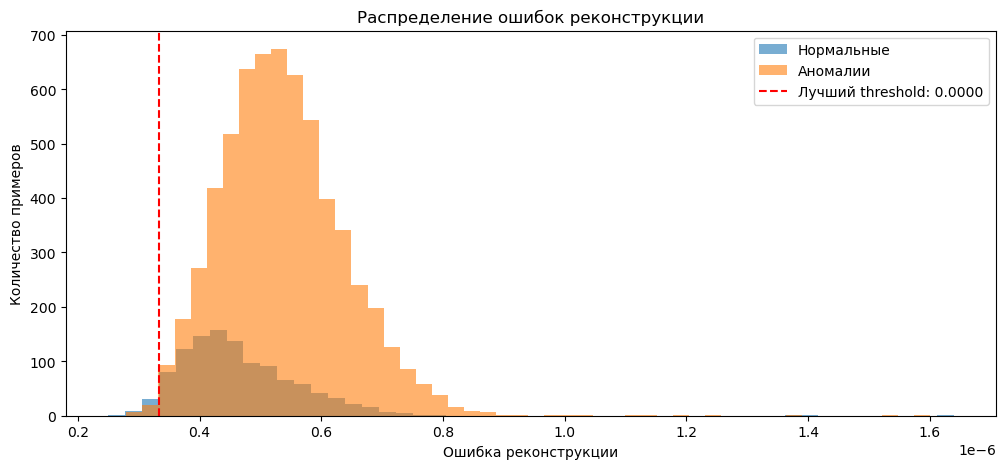

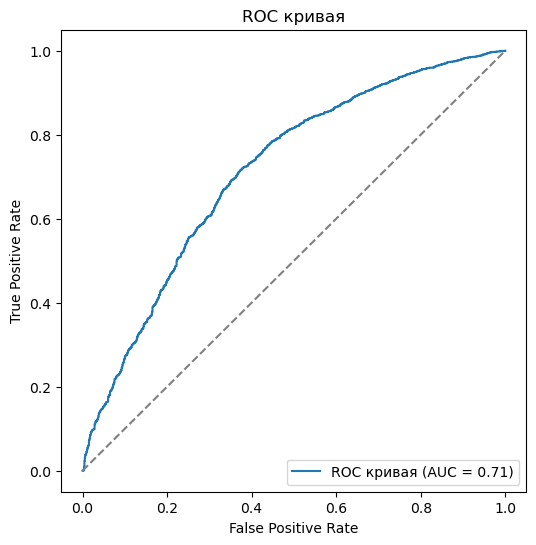

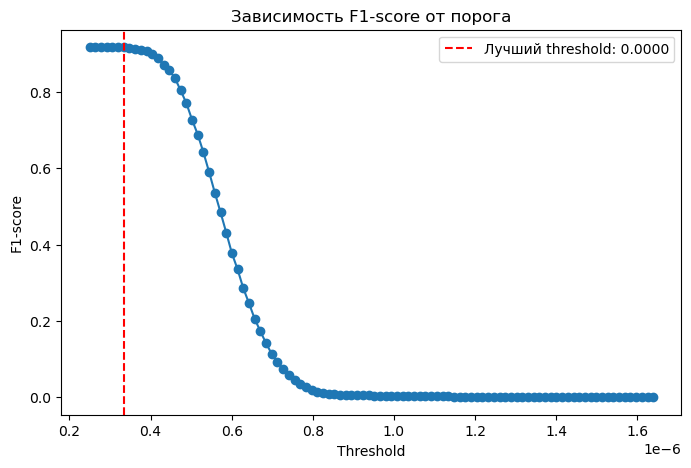

In [26]:
train_attack_category("brute-ssh")


< ---------- inf-dropbox ---------- >


Нет улучшения на валидации, early stopping.
Обучение завершено.
AUROC: 0.3719
Лучший threshold: 0.0000
Accuracy: 0.9771
Precision: 0.9772
Recall: 1.0000
F1: 0.9884
Матрица ошибок:
TN: 0.0000
FP: 2344.0000
FN: 1.0000
TP: 100268.0000


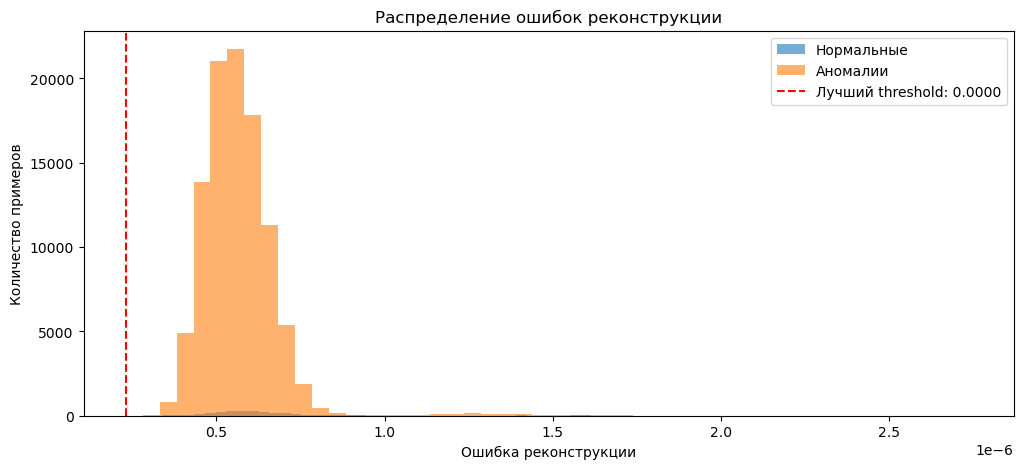

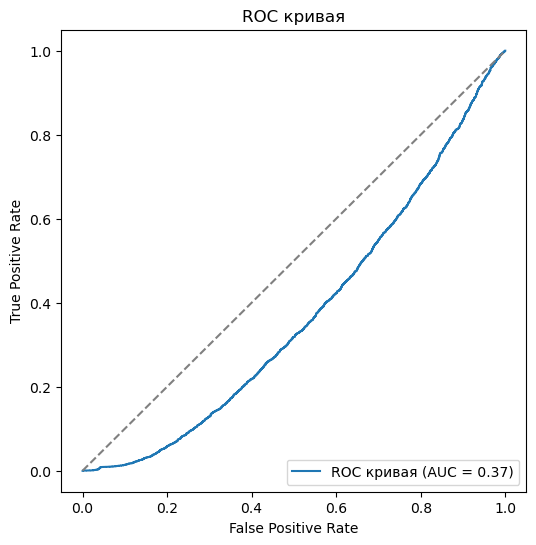

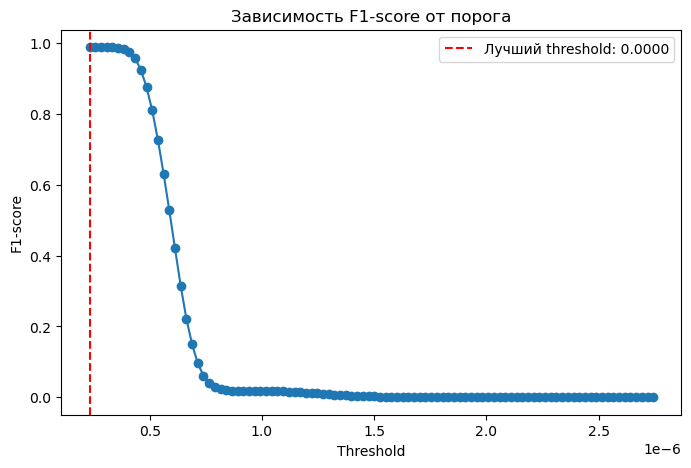

In [27]:
train_attack_category("inf-dropbox")


< ---------- inf-usb ---------- >


Обучение завершено.
AUROC: 0.8987
Лучший threshold: 0.1053
Accuracy: 0.9400
Precision: 0.9404
Recall: 0.9995
F1: 0.9691
Матрица ошибок:
TN: 0.0000
FP: 139.0000
FN: 1.0000
TP: 2192.0000


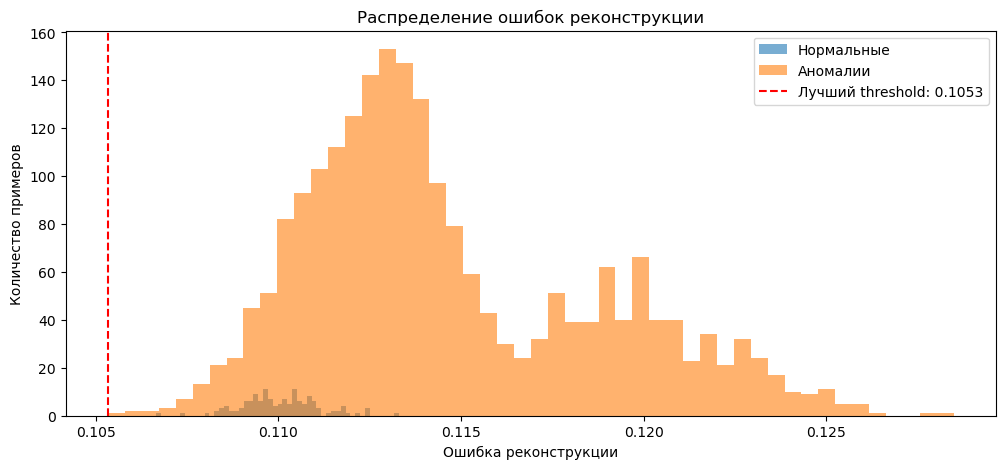

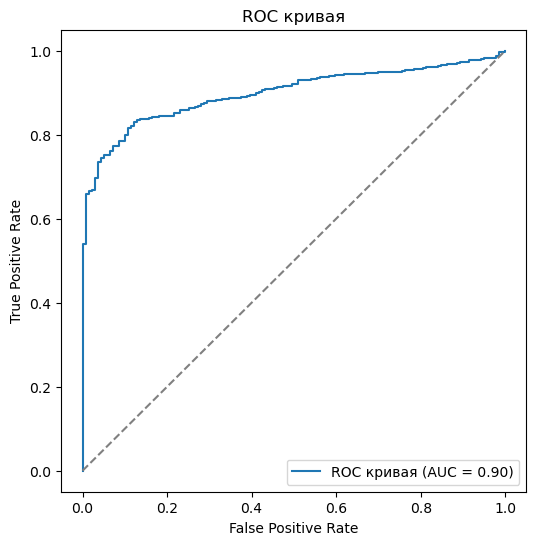

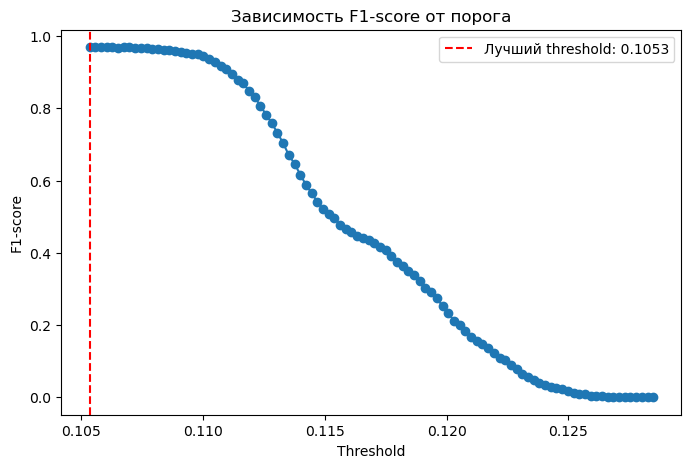

In [28]:
train_attack_category("inf-usb")


< ---------- sql-inj ---------- >


Обучение завершено.
AUROC: 0.9454
Лучший threshold: 0.0940
Accuracy: 0.8939
Precision: 0.8485
Recall: 0.9333
F1: 0.8889
Матрица ошибок:
TN: 31.0000
FP: 5.0000
FN: 2.0000
TP: 28.0000


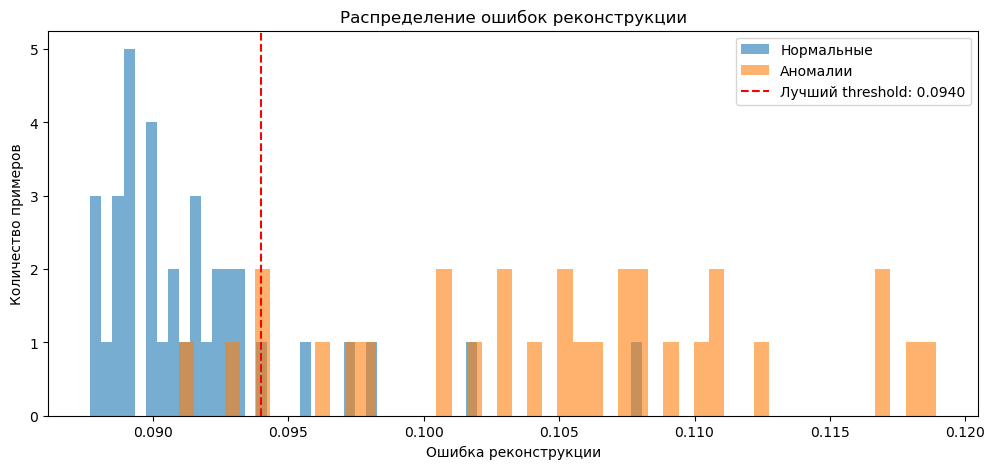

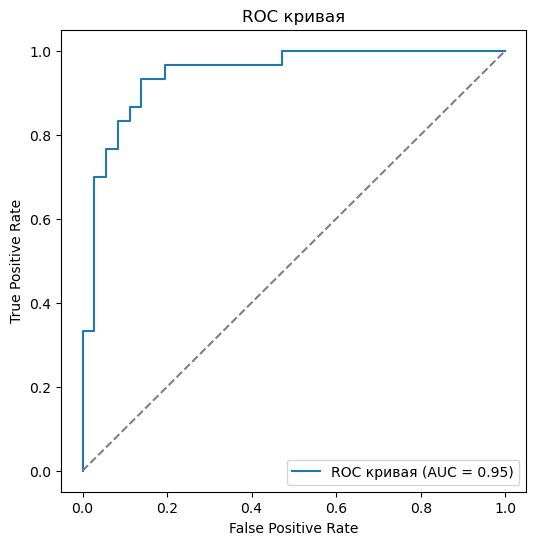

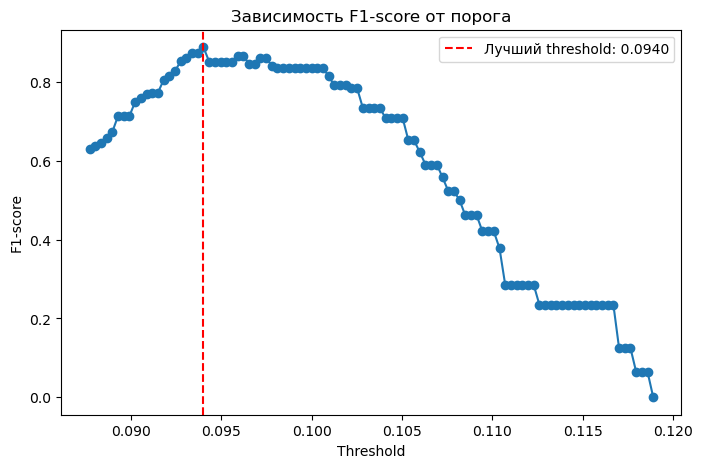

In [29]:
train_attack_category("sql-inj")


< ---------- xss ---------- >


Обучение завершено.
AUROC: 0.7653
Лучший threshold: 0.0322
Accuracy: 0.8815
Precision: 0.8820
Recall: 0.9994
F1: 0.9370
Матрица ошибок:
TN: 0.0000
FP: 209.0000
FN: 1.0000
TP: 1562.0000


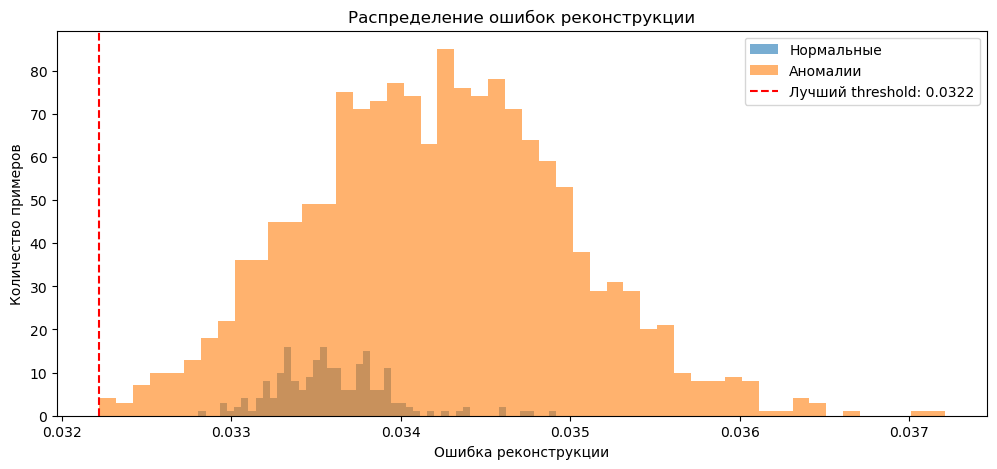

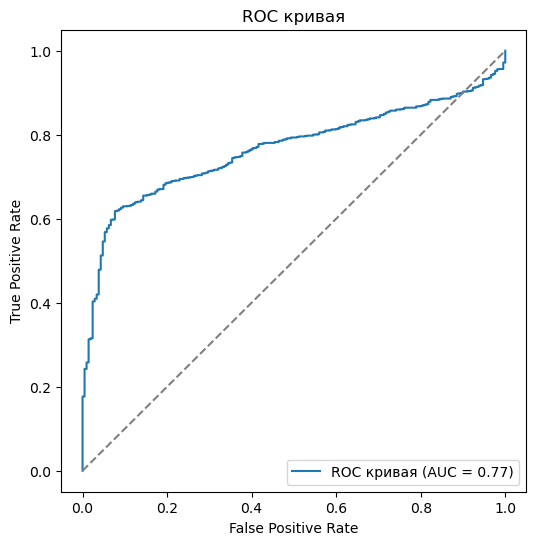

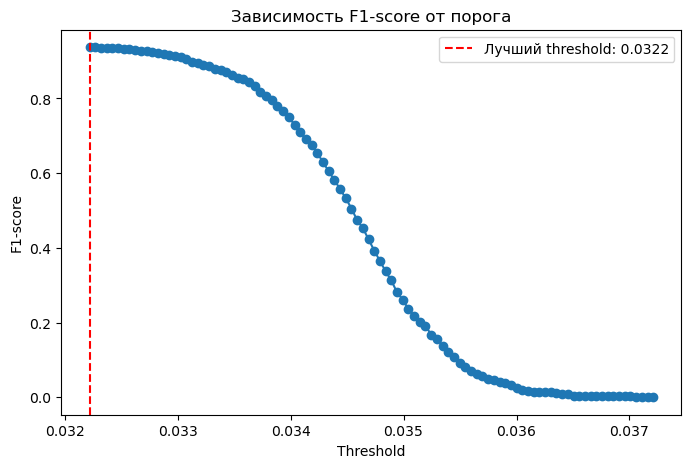

In [30]:
train_attack_category("xss")

In [31]:
# Создаем DataFrame и сохраняем в CSV
base_dir = "n_packets=2_l=100"
results_df = pd.DataFrame(results)
results_df.to_csv(f"{base_dir}_attack_metrics_report.csv", index=False)
print(f"\nMetrics saved to {base_dir}_attack_metrics_report.csv")


Metrics saved to n_packets=2_l=100_attack_metrics_report.csv


In [32]:
results_df

,Attack Category,AUROC,Accuracy,Precision,Recall,F1 Score,True Negative,False Positive,False Negative,True Positive,ROC AUC
0,botnet-ares,0.488818,0.487059,0.487023,1.000000,0.655031,1,7293,0,6924,0.488818
1,brute-ftp,0.896736,0.941318,0.941314,1.000000,0.969770,1,804,0,12896,0.896736
2,brute-http,0.223318,0.845313,0.845544,0.999677,0.916173,0,565,1,3093,0.223318
3,brute-ssh,0.713362,0.847701,0.850546,0.994825,0.917046,43,1081,32,6152,0.713362
4,inf-dropbox,0.371950,0.977147,0.977157,0.999990,0.988442,0,2344,1,100268,0.371950
5,inf-usb,0.898664,0.939966,0.940369,0.999544,0.969054,0,139,1,2192,0.898664
6,sql-inj,0.945370,0.893939,0.848485,0.933333,0.888889,31,5,2,28,0.945370
7,xss,0.765282,0.881490,0.881988,0.999360,0.937013,0,209,1,1562,0.765282


In [ ]:
# =========================
# Оценка AUROC
# =========================
# Модифицированная функция оценки AUROC
# def evaluate_metrics(autoencoder, dataloader, device):
#     all_scores = []
#     all_labels = []
#     autoencoder.eval()
#     with torch.no_grad():
#         for data, labels in dataloader:
#             # Предполагается, что даталоадер для оценки возвращает кортеж (данные, метки),
#             # где метки: 0 – нормальный, 1 – аномалия.
#             data = data.to(device)
#             reconstruction = autoencoder(data)
#             scores = torch.mean((data - reconstruction) ** 2, dim=[1, 2]).cpu().numpy()
#             predictions = (scores > threshold).astype(int)
#             all_scores.extend(scores)
#             all_labels.extend(labels.cpu().numpy())
#
#
#
#     auroc = roc_auc_score(all_labels, all_scores)
#     accuracy = accuracy_score(all_labels, predictions)
#     precision = precision_score(all_labels, predictions)
#     recall = recall_score(all_labels, predictions)
#     f1 = f1_score(all_labels, predictions)
#
#     print(f"AUROC: {auroc:.4f}")
#     return auroc

# def evaluate_auroc(autoencoder, dataloader, device):
#     all_scores = []
#     all_labels = []
#     autoencoder.eval()
#     with torch.no_grad():
#         for data, labels in dataloader:
#             # Предполагается, что даталоадер для оценки возвращает кортеж (данные, метки),
#             # где метки: 0 – нормальный, 1 – аномалия.
#             data = data.to(device)
#             reconstruction = autoencoder(data)
#             # Вычисляем ошибку реконструкции как аномальный скор (например, MSE по образцу)
#             scores = torch.mean((data - reconstruction) ** 2, dim=[1, 2]).cpu().numpy()
#             all_scores.extend(scores)
#             all_labels.extend(labels.cpu().numpy())
#     auroc = roc_auc_score(all_labels, all_scores)
#     print(f"AUROC: {auroc:.4f}")
#     return auroc

In [ ]:
# # Пример использования
# attack_category = 'botnet-ares'
# base_dir = 'n_packets=2_l=100'

# # Создаем Dataset только для нормального трафика для обучения
# train_dataset = CSVAttackDataset(
#         attack_dir=os.path.join(base_dir, attack_category),
#         data_type='normal'
#         )

# # Разбиение на train/validation
# train_size = int(0.95 * len(train_dataset))
# val_size = len(train_dataset) - train_size
# train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# # Тестовый набор (attack + normal)
# test_dataset = CombinedTestDataset(os.path.join(base_dir, attack_category))

In [ ]:
# # Создаем DataLoader-ы
# batch_size = 32

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# # Инициализация моделей
# autoencoder = Autoencoder().to(device)
# critic = Critic().to(device)

# # Обучение ARCADE
# train_arcade(autoencoder, critic, train_dataloader, device)

# # Оценка на комбинированных данных
# metrics = evaluate_metrics(autoencoder, test_dataloader, device)

In [ ]:
# # Инициализация моделей
# autoencoder = Autoencoder().to(device)
# critic = Critic().to(device)

# # Обучение ARCADE
# searching_epochs = 10  # Фаза "searching"
# fine_tuning_epochs = 5  # Фаза "fine-tuning"
# train_arcade(autoencoder, critic, train_dataloader, device, searching_epochs, fine_tuning_epochs)

# # Оценка на комбинированных данных
# metrics = evaluate_metrics(autoencoder, test_dataloader, device)

In [ ]:
# def train_all_base_dir(base_dir):
#     results = []
#     for attack_category in os.listdir(base_dir):
#         print(f"\n{attack_category}")

#         # Создаем Dataset только для нормального трафика для обучения
#         train_dataset = CSVAttackDataset(
#                 attack_dir=os.path.join(base_dir, attack_category),
#                 data_type='normal'
#                 )

#         # Разбиение на train/validation
#         train_size = int(0.95 * len(train_dataset))
#         val_size = len(train_dataset) - train_size
#         train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

#         # Тестовый набор (attack + normal)
#         test_dataset = CombinedTestDataset(os.path.join(base_dir, attack_category))

#         # Создаем DataLoader-ы
#         batch_size = 32

#         train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#         val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
#         test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#         # Инициализация моделей
#         autoencoder = Autoencoder().to(device)
#         critic = Critic().to(device)

#         # Обучение ARCADE
#         searching_epochs = 10  # Фаза "searching"
#         fine_tuning_epochs = 5  # Фаза "fine-tuning"
#         train_arcade(autoencoder, critic, train_dataloader, device, searching_epochs, fine_tuning_epochs)

#         # Оценка и сохранение метрик
#         auroc, predictions, accuracy, precision, recall, f1, tn, fp, fn, tp = evaluate_metrics(autoencoder,
#                                                                                                test_dataloader,
#                                                                                                device
#                                                                                                )

#         # Добавляем результат в список
#         results.append({
#                 'Attack Category': attack_category,
#                 'AUROC'          : auroc,
#                 'Accuracy'       : accuracy,
#                 'Precision'      : precision,
#                 'Recall'         : recall,
#                 'F1 Score'       : f1,
#                 'True Negative'  : tn,
#                 'False Positive' : fp,
#                 'False Negative' : fn,
#                 'True Positive'  : tp,
#                 }
#                 )
#         print()

#     # Создаем DataFrame и сохраняем в CSV
#     results_df = pd.DataFrame(results)
#     results_df.to_csv(f'{base_dir}_attack_metrics_report.csv', index=False)
#     print(f"\nMetrics saved to {base_dir}_attack_metrics_report.csv")

#     return results_df

In [ ]:
# base_dir = 'n_packets=2_l=100'
# train_all_base_dir(base_dir)

In [ ]:
# base_dir = 'n_packets=5_l=100'
# train_all_base_dir(base_dir)

In [ ]:
# # =========================
# # Пример использования
# # =========================
# if __name__ == "__main__":
#     # Гиперпараметры
#     # latent_dim = 100
#     num_epochs = 10
#     batch_size = 64
#
#     # Инициализация моделей
#     autoencoder = Autoencoder().to(device)
#     critic = Critic().to(device)
#
#
#     # Здесь должен быть ваш датасет, например, обёрнутый в DataLoader
#     # dataset = YourCustomDataset(...)
#     # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
#     #
#     # Для демонстрации создадим фиктивные данные:
#     class DummyDataset(Dataset):
#         def __init__(self, num_samples=10000, seq_len=200):
#             self.data = torch.rand(num_samples, 1, seq_len)
#
#         def __len__(self):
#             return len(self.data)
#
#         def __getitem__(self, idx):
#             return self.data[idx]
#
#
#     # train_dataset = DummyDataset()
#     # train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#
#     # Обучение ARCADE
#     train_arade(autoencoder, critic, train_dataloader, num_epochs, device)
#
#
#     # Для оценки AUROC предполагается наличие тестового датасета с метками
#     # Здесь создаём dummy test dataset с метками (0 - нормальный, 1 - аномалия)
#     class DummyTestDataset(Dataset):
#         def __init__(self, num_samples=1000, seq_len=200):
#             self.data = torch.rand(num_samples, 1, seq_len)
#             # Примерно половина аномальных (метка 1) – для демонстрации
#             self.labels = torch.cat([torch.zeros(num_samples // 2), torch.ones(num_samples // 2)])
#
#         def __len__(self):
#             return len(self.data)
#
#         def __getitem__(self, idx):
#             return self.data[idx], self.labels[idx]
#
#
#     # test_dataset = DummyTestDataset()
#     test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
#
#     # Вычисляем AUROC (аналогично вычислению по ошибке реконструкции)
#     evaluate_auroc(autoencoder, test_dataloader, device)

6. Оценка и детектирование аномалий

После завершения обучения:

- Аномалия: Вычисляется ошибка реконструкции (например, MSE) между входными данными и их реконструкцией. Потоки с высокой ошибкой считаются аномальными.

- Порог: Можно определить порог, основываясь на распределении ошибок на валидационном наборе нормальных данных.

Пример кода для оценки:

In [ ]:
# def compute_anomaly_score(model, data, device):
#     model.eval()
#     with torch.no_grad():
#         reconstruction = model(data.to(device))
#         loss = ((reconstruction - data.to(device)) ** 2).mean(dim=[1, 2])
#     return loss.cpu().numpy()